# Get embeddings from dataset

This notebook gives an example on how to get embeddings from a large dataset.
This was written by some Schmoe at OpenAI


## 1. Load the dataset

The dataset used in this example is [fine-food reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews) from Amazon. The dataset contains a total of 568,454 food reviews Amazon users left up to October 2012. We will use a subset of this dataset, consisting of 1,000 most recent reviews for illustration purposes. The reviews are in English and tend to be positive or negative. Each review has a ProductId, UserId, Score, review title (Summary) and review body (Text).

We will combine the review summary and review text into a single combined text. The model will encode this combined text and it will output a single vector embedding.

To run this notebook, you will need to install: pandas, openai, transformers, plotly, matplotlib, scikit-learn, torch (transformer dep), torchvision, and scipy.

In [1]:
import pandas as pd
import tiktoken

from utils.embeddings_utils import get_embedding
# In utils folder, read first method, this is just a helper function
# Can this be replaced by openai.embeddings_utils?

In [2]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [3]:
# load & inspect dataset
input_datapath = "data/fine_food_reviews_1k.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [4]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [11]:
df.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.036636363714933395, -0.023187169805169106, ..."
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07047566026449203, -0.031760234385728836, ..."


## 2. Get embeddings and save them for future reuse

Completed 1,002 requests, and used 95,945 context tokens. Cost less than 1 cent USD

In [6]:
# Ensure you have your API key set in your environment per the README: https://github.com/openai/openai-python#usage

# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))
df.to_csv("data/fine_food_reviews_with_embeddings_1k.csv")

In [13]:
test_string = "A token is a discrete unit of data fed into a transformer. It is not as simple as a letter or a word, instead it is a discrete portion of a word, communicating meaning. Any English word will probably contain 1-3 words"

In [16]:
len(test_string.split(" "))

42

In [15]:
tokens = encoding.encode(test_string)
len(tokens)

49

## Using Embeddings, Zero Shot Learning

This was written by Booter Mc Booter, with code from OpenAI Platform embeddings docs

Our first example uses zero shot learning. We compute the embeddings of the labels of the dataset, in this case 'negative' and 'positive.' Then, we calculate the proximity of each datapoint relative to each label, using their embeddings. This method tends itself datasets with few labeled data, where the class labels are predictable, known, and definite. 

In [20]:
from utils.embeddings_utils import cosine_similarity

df= df[df.Score!=3]
df['sentiment'] = df.Score.replace({1:'negative', 2:'negative', 4:'positive', 5:'positive'})

labels = ['negative', 'positive']
label_embeddings = [get_embedding(label, model=embedding_model) for label in labels]

def label_score(review_embedding, label_embeddings):
   # If the result is positive, the it is more similar to a positive review, if negative, it is more similar to a negative review
   return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

# Example Usage
first_row_prediction = df.iloc[0]['sentiment']
first_row_embedding = df.iloc[0]['embedding']
prediction = 'positive' if label_score(first_row_embedding, label_embeddings) > 0 else 'negative'

print(f"Predicted: {prediction}, Actual: {first_row_prediction}")

Predicted: positive, Actual: positive


In [19]:
import numpy as np
np.shape(label_embeddings)

(2, 1536)

In [21]:
df['prediction'] = df.embedding.apply(lambda x: 'positive' if label_score(x, label_embeddings) > 0 else 'negative')

### Assessment

In [22]:
from sklearn.metrics import f1_score

f1 = f1_score(df.sentiment, df.prediction, average='weighted', labels=['positive', 'negative'])
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.89


## Random Forest Supervised Learning

In contrast to the above, I predict the Recommendation Classifier to have a fair amount of labelled data. Boundaries of preference will also be undefined, so Zero Shot Learning is most likely unviable. Instead, classifying using Supervised learning is preferable. Here, I will use random forests to determine the boundaries between Amazon reviews. 

In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [10]:
import pandas as pd

df = pd.read_csv("data/fine_food_reviews_with_embeddings_1k.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to array

In [11]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.Score, test_size=0.2, random_state=42
)


In [13]:
X_train[0]

array([-0.07287188, -0.00253062, -0.04637074, ...,  0.05275203,
        0.00520513, -0.00509878])

In [14]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           1       1.00      0.50      0.67        20
           2       0.75      0.38      0.50         8
           3       1.00      0.18      0.31        11
           4       0.88      0.26      0.40        27
           5       0.76      1.00      0.86       134

    accuracy                           0.78       200
   macro avg       0.88      0.46      0.55       200
weighted avg       0.81      0.78      0.74       200



RandomForestClassifier() - Average precision score over all classes: 0.88


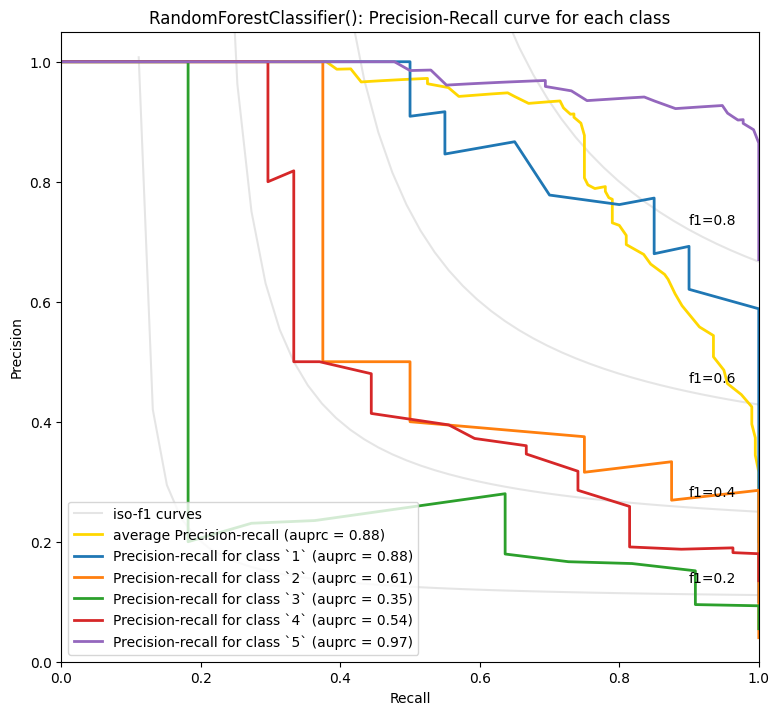

In [15]:
from utils.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, [1, 2, 3, 4, 5], clf)